# Dataset Information

### Import the Necessary Libraries :

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
import missingno as msno

from itertools import combinations
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA as ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smt
pd.options.display.float_format = '{:.2f}'.format

In [64]:
data = pd.read_csv('../data/avocado.csv')
data = data.drop('Unnamed: 0',axis = 1)
data.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.00,conventional,2015,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.00,conventional,2015,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.00,conventional,2015,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.00,conventional,2015,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.00,conventional,2015,Albany


### Data Info :

In [65]:
data.shape

(18249, 13)

In [66]:
data.columns

Index(['Date', 'AveragePrice', 'Total Volume', '4046', '4225', '4770',
       'Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags', 'type', 'year',
       'region'],
      dtype='object')

In [67]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          18249 non-null  object 
 1   AveragePrice  18249 non-null  float64
 2   Total Volume  18249 non-null  float64
 3   4046          18249 non-null  float64
 4   4225          18249 non-null  float64
 5   4770          18249 non-null  float64
 6   Total Bags    18249 non-null  float64
 7   Small Bags    18249 non-null  float64
 8   Large Bags    18249 non-null  float64
 9   XLarge Bags   18249 non-null  float64
 10  type          18249 non-null  object 
 11  year          18249 non-null  int64  
 12  region        18249 non-null  object 
dtypes: float64(9), int64(1), object(3)
memory usage: 1.8+ MB


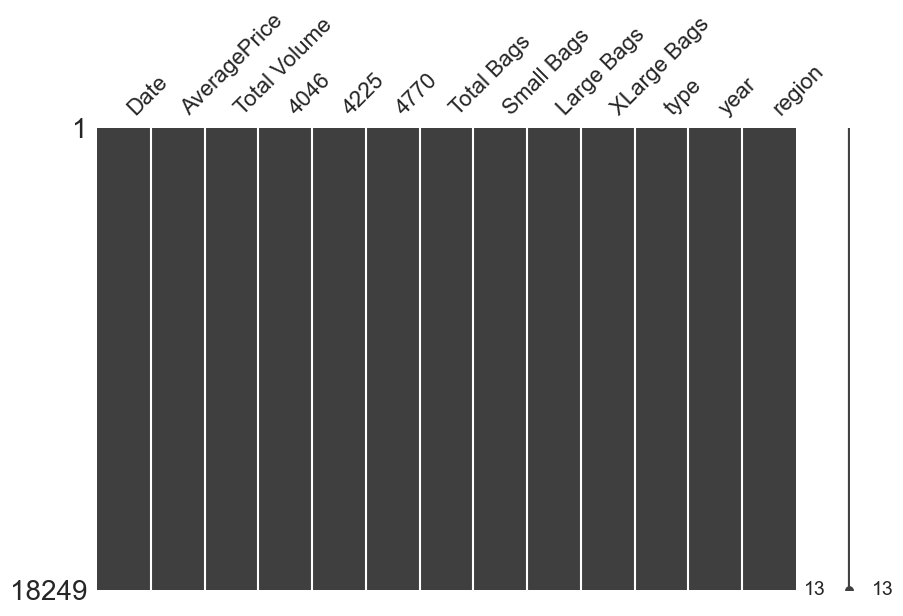

In [68]:
msno.matrix(data, figsize=(10, 6))
plt.show()

- No null values present in the data

In [69]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
AveragePrice,18249.00,1.41,0.40,0.44,1.10,1.37,1.66,3.25
Total Volume,18249.00,850644.01,3453545.36,84.56,10838.58,107376.76,432962.29,62505646.52
4046,18249.00,293008.42,1264989.08,0.00,854.07,8645.30,111020.20,22743616.17
4225,18249.00,295154.57,1204120.40,0.00,3008.78,29061.02,150206.86,20470572.61
4770,18249.00,22839.74,107464.07,0.00,0.00,184.99,6243.42,2546439.11
Total Bags,18249.00,239639.20,986242.40,0.00,5088.64,39743.83,110783.37,19373134.37
Small Bags,18249.00,182194.69,746178.51,0.00,2849.42,26362.82,83337.67,13384586.80
Large Bags,18249.00,54338.09,243965.96,0.00,127.47,2647.71,22029.25,5719096.61
XLarge Bags,18249.00,3106.43,17692.89,0.00,0.00,0.00,132.50,551693.65
year,18249.00,2016.15,0.94,2015.00,2015.00,2016.00,2017.00,2018.00


In [70]:
df1 = data.copy(deep = True)
df1['Date'] = pd.to_datetime(df1['Date'])
df1.set_index('Date',inplace = True)
df1 = df1.resample('W').sum()
df1.head()

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
Date,,,,,,,,,,,,
2015-01-04,140.54,84674337.20,33098258.74,36851038.43,2278818.64,12446221.39,9910008.90,2485655.90,50556.59,conventionalconventionalconventionalconvention...,217620,AlbanyAtlantaBaltimoreWashingtonBoiseBostonBuf...
2015-01-11,148.03,78555807.24,31024164.99,32808429.84,2349167.45,12374044.96,10352936.42,1977832.00,43276.54,conventionalconventionalconventionalconvention...,217620,AlbanyAtlantaBaltimoreWashingtonBoiseBostonBuf...
2015-01-18,150.24,78388784.08,31802706.86,31662041.93,2208250.55,12715784.74,10548854.11,2145586.13,21344.50,conventionalconventionalconventionalconvention...,217620,AlbanyAtlantaBaltimoreWashingtonBoiseBostonBuf...
2015-01-25,150.89,76466281.07,32305132.87,28929122.37,2078378.86,13153646.97,10877316.95,2252815.92,23514.10,conventionalconventionalconventionalconvention...,217620,AlbanyAtlantaBaltimoreWashingtonBoiseBostonBuf...
2015-02-01,134.68,119453235.25,50292988.96,50696230.48,3687489.31,14776526.50,11576833.65,3073989.39,125703.46,conventionalconventionalconventionalconvention...,217620,AlbanyAtlantaBaltimoreWashingtonBoiseBostonBuf...


# Exploratory Data Analysis

### Target Variable Visualization (AveragePrice) : 

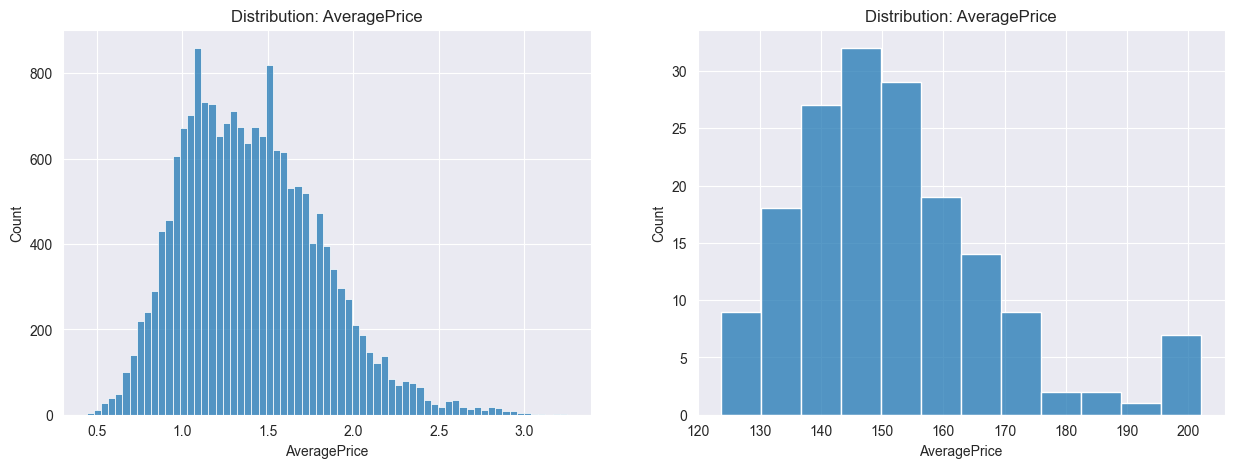

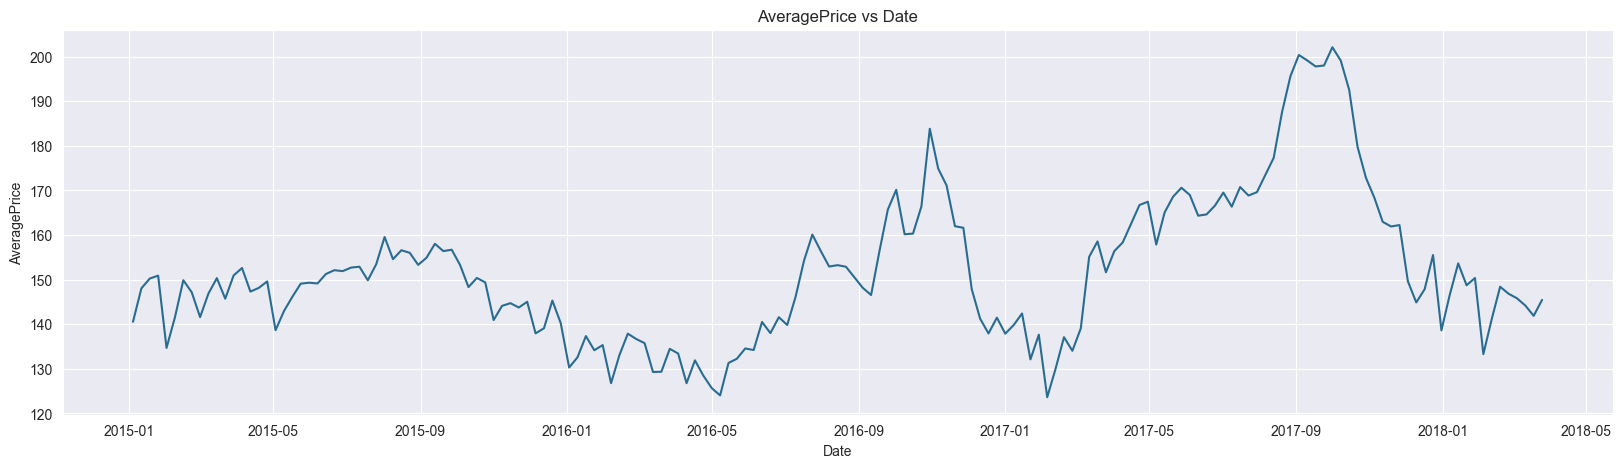

In [71]:
color1 = ['#296C92', '#3EB489']

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.histplot(data['AveragePrice'])
plt.title('Distribution: AveragePrice')

plt.subplot(1, 2, 2)
sns.histplot(df1['AveragePrice'])
plt.title('Distribution: AveragePrice')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))

plt.subplot(1, 1, 1)
sns.lineplot(x=df1.index, y='AveragePrice', data=df1, color=color1[0])
plt.title('AveragePrice vs Date')

plt.show()
fig.tight_layout(pad=2)

# Time Series Analysis

In [72]:
df1 = data.copy(deep = True)
df1['Date'] = pd.to_datetime(df1['Date'])
df1.set_index('Date',inplace = True)
df1 = df1.resample('W').sum()
df1.head()

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
Date,,,,,,,,,,,,
2015-01-04,140.54,84674337.20,33098258.74,36851038.43,2278818.64,12446221.39,9910008.90,2485655.90,50556.59,conventionalconventionalconventionalconvention...,217620,AlbanyAtlantaBaltimoreWashingtonBoiseBostonBuf...
2015-01-11,148.03,78555807.24,31024164.99,32808429.84,2349167.45,12374044.96,10352936.42,1977832.00,43276.54,conventionalconventionalconventionalconvention...,217620,AlbanyAtlantaBaltimoreWashingtonBoiseBostonBuf...
2015-01-18,150.24,78388784.08,31802706.86,31662041.93,2208250.55,12715784.74,10548854.11,2145586.13,21344.50,conventionalconventionalconventionalconvention...,217620,AlbanyAtlantaBaltimoreWashingtonBoiseBostonBuf...
2015-01-25,150.89,76466281.07,32305132.87,28929122.37,2078378.86,13153646.97,10877316.95,2252815.92,23514.10,conventionalconventionalconventionalconvention...,217620,AlbanyAtlantaBaltimoreWashingtonBoiseBostonBuf...
2015-02-01,134.68,119453235.25,50292988.96,50696230.48,3687489.31,14776526.50,11576833.65,3073989.39,125703.46,conventionalconventionalconventionalconvention...,217620,AlbanyAtlantaBaltimoreWashingtonBoiseBostonBuf...


In [73]:
l3 = list(df1.columns)
l3.remove('AveragePrice')

df1.drop(columns = l3,inplace =True)
df1.head()

,AveragePrice
Date,
2015-01-04,140.54
2015-01-11,148.03
2015-01-18,150.24
2015-01-25,150.89
2015-02-01,134.68


### Supportive Functions for TIme Series Analysis :

In [74]:
def test_stationarity(timeseries):
    MA = timeseries.rolling(window = 12).mean()
    MSTD = timeseries.rolling(window = 12).std()

    plt.figure(figsize=(15,5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(MA, color='red', label='Rolling Mean')
    std = plt.plot(MSTD, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [75]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

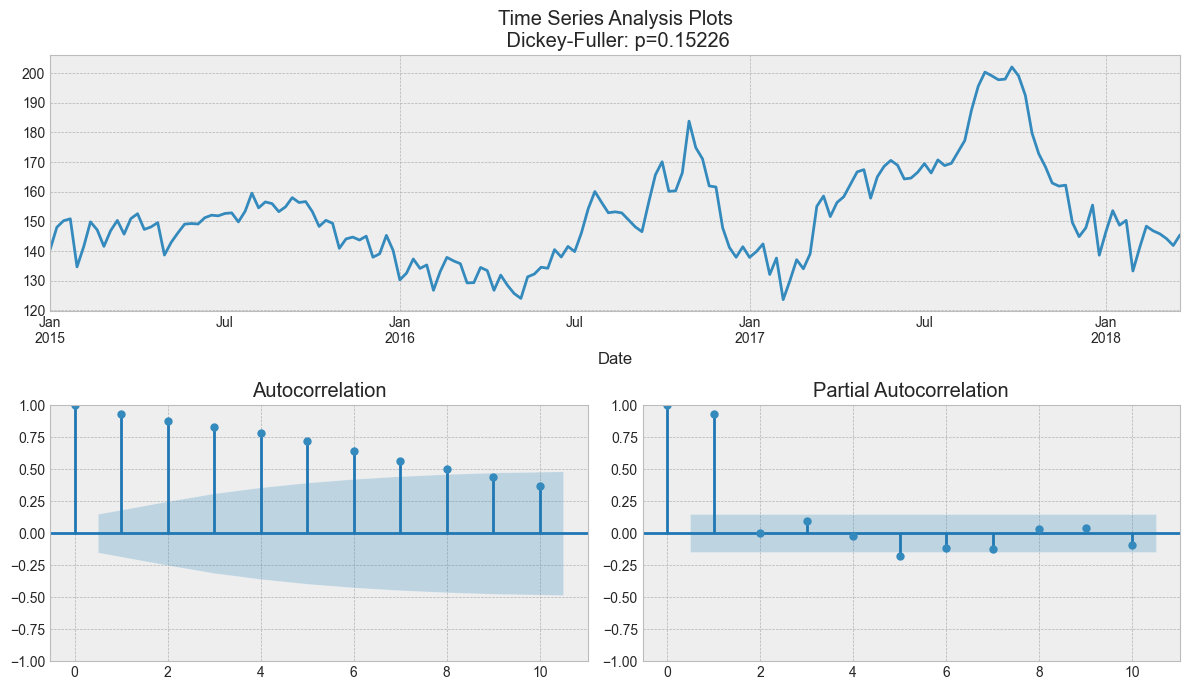

In [76]:
tsplot(df1['AveragePrice'],lags = 10)

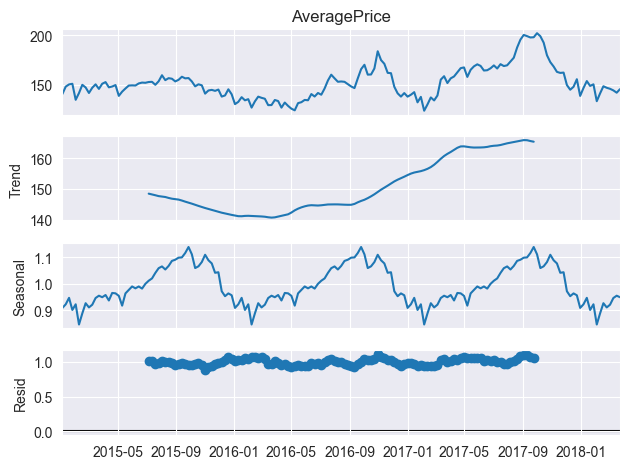

In [77]:
dec = sm.tsa.seasonal_decompose(df1['AveragePrice'], model = 'multiplicative').plot()
plt.show();

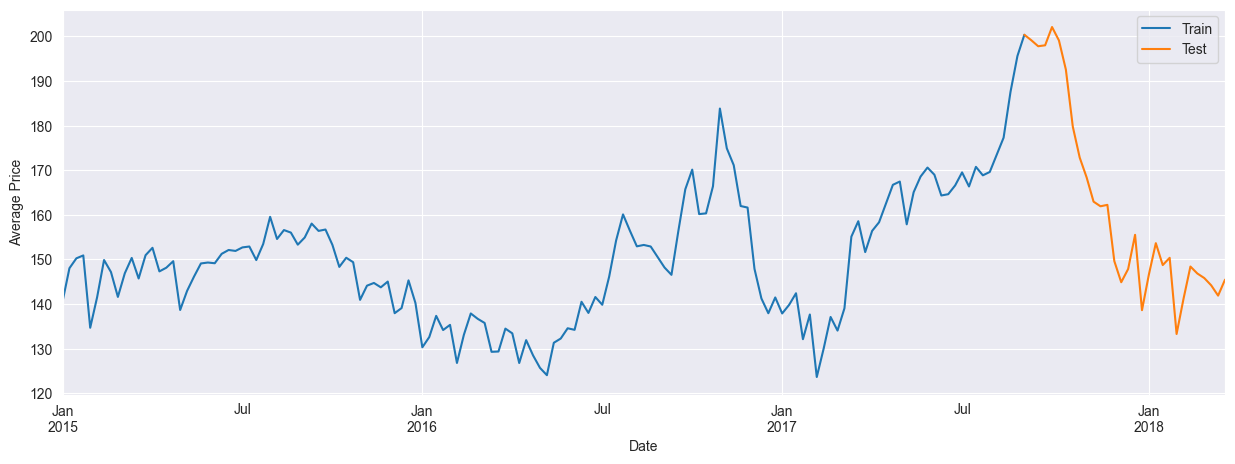

In [78]:
test_start_date = '2017-09-03'
train_data = df1.loc[:test_start_date]
test_data = df1.loc[test_start_date:]

ax = train_data.plot(figsize=(15, 5))
test_data.plot(ax=ax)
plt.legend(['Train', 'Test'])
plt.xlabel('Date')
plt.ylabel('Average Price')
plt.show()


# **Building ARIMA Model**

**Finding stationarity**

In [79]:
result = adfuller(train_data)

print(f"Test Statistic: { result[0]}")
print(f"P-value: {result[1]}")
print('Stationary' if result[1] < 0.05 else 'Non-Stationary')

Test Statistic: -0.9711584462543636
P-value: 0.7636377379717412
Non-Stationary


**First difference**

Test Statistic: -11.945005327347445
P-value: 4.451449029284079e-22
Stationary


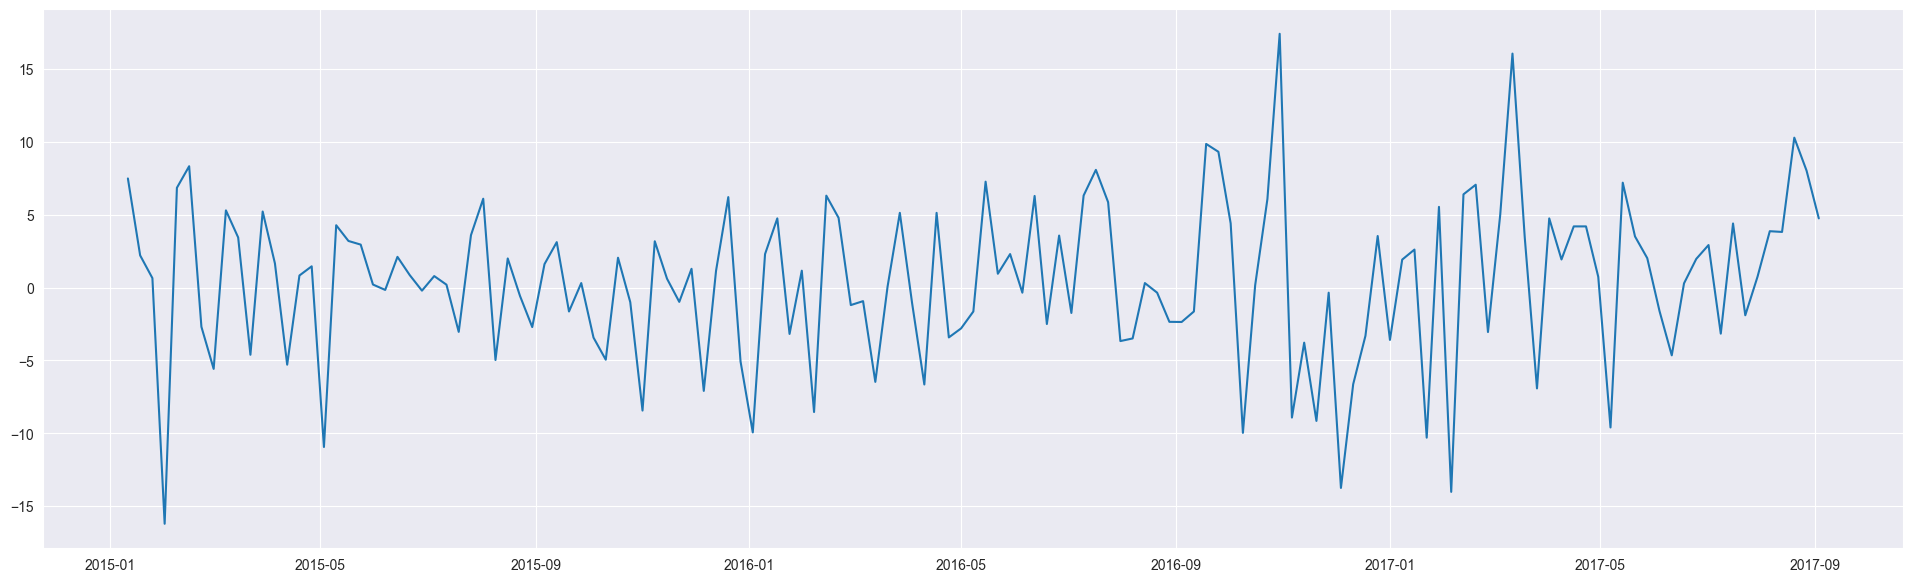

In [80]:
diff1 = train_data.diff().dropna()

result = adfuller(diff1)

print(f"Test Statistic: {result[0]}")
print(f"P-value: {result[1]}")
print('Stationary' if result[1] < 0.05 else 'Non-Stationary')

plt.figure(figsize=(24,7)) 
plt.plot(diff1)
plt.show()

In [81]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

arima = SARIMAX(train_data, order = (2,1,2)) 
arima_fit = arima.fit()
print(arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:           AveragePrice   No. Observations:                  140
Model:               SARIMAX(2, 1, 2)   Log Likelihood                -429.513
Date:                Tue, 09 Jan 2024   AIC                            869.025
Time:                        18:16:12   BIC                            883.697
Sample:                    01-04-2015   HQIC                           874.987
                         - 09-03-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6491      0.042     15.520      0.000       0.567       0.731
ar.L2         -0.9436      0.039    -24.143      0.000      -1.020      -0.867
ma.L1         -0.7528      0.731     -1.030      0.3

C:\Users\dmytr\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Long-term prediction

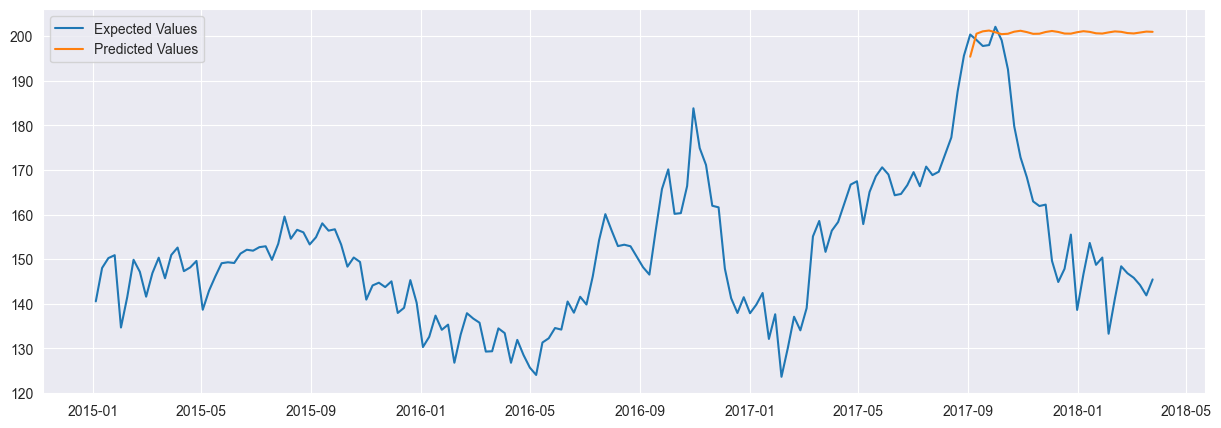

In [82]:
predictions = arima_fit.predict(start=test_start_date, end="2018-03-25")

fig,ax = plt.subplots(nrows = 1,ncols = 1,figsize = (15,5))

plt.subplot(1,1,1)
plt.plot(df1, label = 'Expected Values')
plt.plot(predictions, label = 'Predicted Values');
plt.legend(loc="upper left")
plt.show()

In [83]:
from sklearn.metrics import r2_score

print('Test RMSE: %.4f' % np.sqrt(mean_squared_error(test_data, predictions)))
print(f'R2: {r2_score(test_data, predictions)}')

Test RMSE: 44.0991
R2: -2.9989516681295534


### Rolling forecast

In [84]:
size = test_data.size
train, test = train_data['AveragePrice'], test_data['AveragePrice']

print('\t ARIMA MODEL : In - Sample Forecasting \n')

history = [x for x in train]
predictions = []

for t in range(len(test)):

    model = SARIMAX(history, order = (2,1,2))
    model_fit = model.fit()
    
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    
    obs = test[t]
    history.append(obs)
    
    print('predicted = %f, expected = %f' % (yhat, obs))

	 ARIMA MODEL : In - Sample Forecasting 


C:\Users\dmytr\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 200.542286, expected = 200.360000
predicted = 200.913339, expected = 199.140000
predicted = 199.510840, expected = 197.790000


C:\Users\dmytr\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 197.607494, expected = 198.000000


C:\Users\dmytr\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 197.428398, expected = 202.100000
predicted = 201.560796, expected = 199.080000


C:\Users\dmytr\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 199.560136, expected = 192.550000


C:\Users\dmytr\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 194.052134, expected = 179.770000
predicted = 181.542964, expected = 172.820000
predicted = 174.923105, expected = 168.380000
predicted = 168.693812, expected = 162.950000
predicted = 162.544010, expected = 161.910000


C:\Users\dmytr\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 162.012543, expected = 162.230000


C:\Users\dmytr\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 162.686405, expected = 149.620000
predicted = 150.794173, expected = 144.880000
predicted = 145.789979, expected = 147.850000
predicted = 147.472080, expected = 155.510000


C:\Users\dmytr\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 153.891255, expected = 138.620000


C:\Users\dmytr\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 138.318499, expected = 146.640000
predicted = 148.274602, expected = 153.640000
predicted = 153.984073, expected = 148.730000
predicted = 147.476523, expected = 150.360000
predicted = 149.298109, expected = 133.280000
predicted = 134.507605, expected = 141.160000
predicted = 143.020631, expected = 148.400000
predicted = 147.258920, expected = 146.840000
predicted = 144.276417, expected = 145.820000
predicted = 145.234453, expected = 144.190000
predicted = 146.260574, expected = 141.880000
predicted = 144.032225, expected = 145.460000


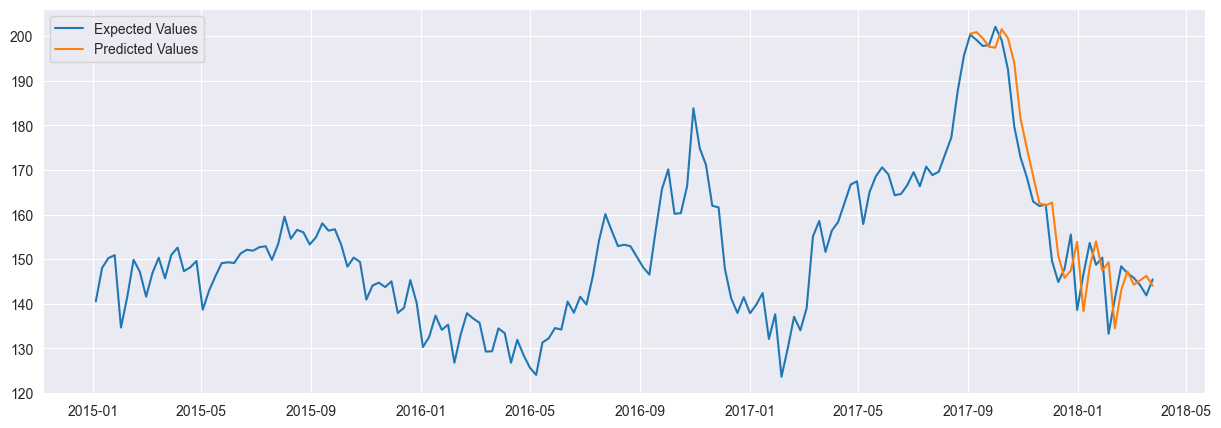

In [85]:
fig,ax = plt.subplots(nrows = 1,ncols = 1,figsize = (15,5))

plt.subplot(1,1,1)
plt.plot(df1, label = 'Expected Values')
plt.plot(pd.Series(predictions, index = test.index), label = 'Predicted Values');
plt.legend(loc="upper left")
plt.show()

In [86]:
print('Test RMSE: %.4f' % np.sqrt(mean_squared_error(test_data, predictions)))
print(f'R2: {r2_score(test_data, predictions)}')

Test RMSE: 6.9188
R2: 0.9015640925650245
